## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
runs = [306121, 306122, 306125, 306126]
#runs = [306121, 306122, 306126]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306121
Loading 306122
Loading 306125
Loading 306126
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [5]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [6]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [7]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [8]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [9]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [10]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

306121 2017-11-03 13:10:09 2017-11-03 13:52:52 42 152 111
306122 2017-11-03 13:53:18 2017-11-03 14:46:08 1 137 137
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007
306126 2017-11-04 10:14:24 2017-11-04 13:28:39 1 501 501


Reindexing the dataframe after removing some lines:

In [11]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [12]:
print len(int_lumi2.index)

3756


Filling end time column:

In [13]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Plotting the instantaneous luminosities:

In [14]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

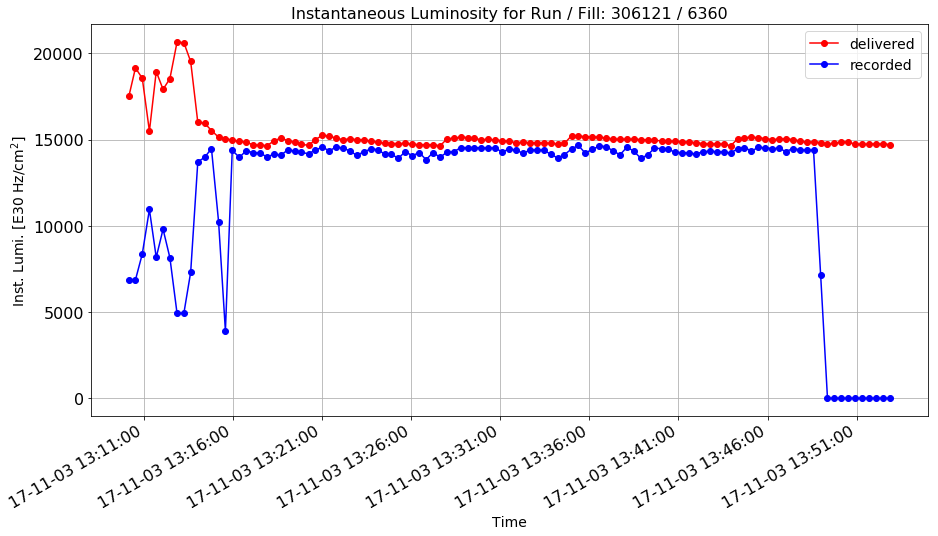

In [15]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306121]["time"], 
               int_lumi2[int_lumi2["run"] == 306121]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306121]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[0], int_lumi2["fill"].iloc[0])))

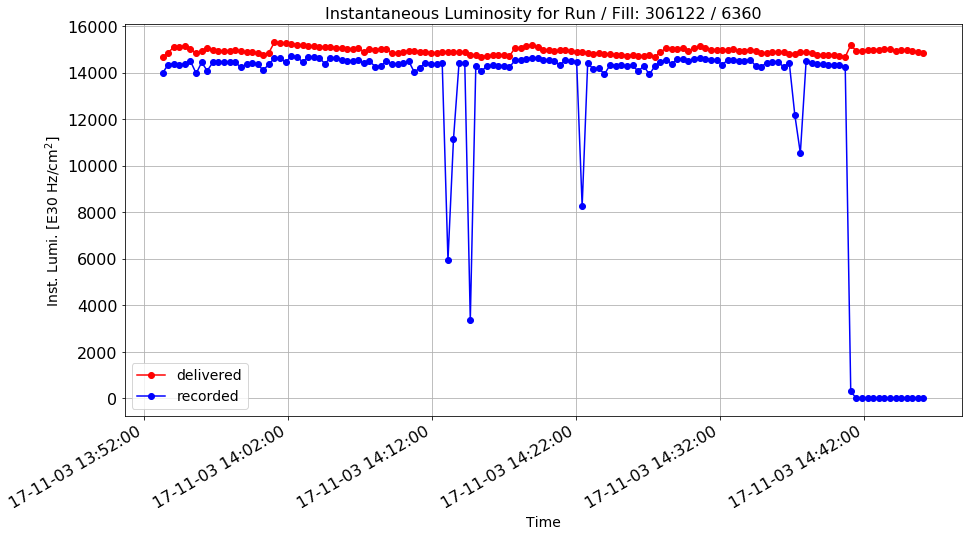

In [16]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306122]["time"], 
               int_lumi2[int_lumi2["run"] == 306122]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306122]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[1], int_lumi2["fill"].iloc[0])))

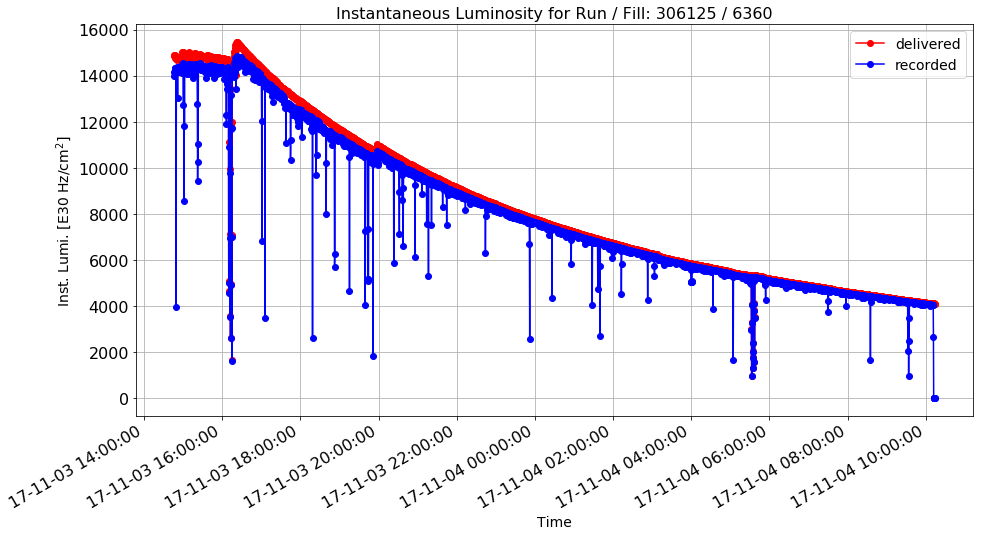

In [17]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[2], int_lumi2["fill"].iloc[0])))

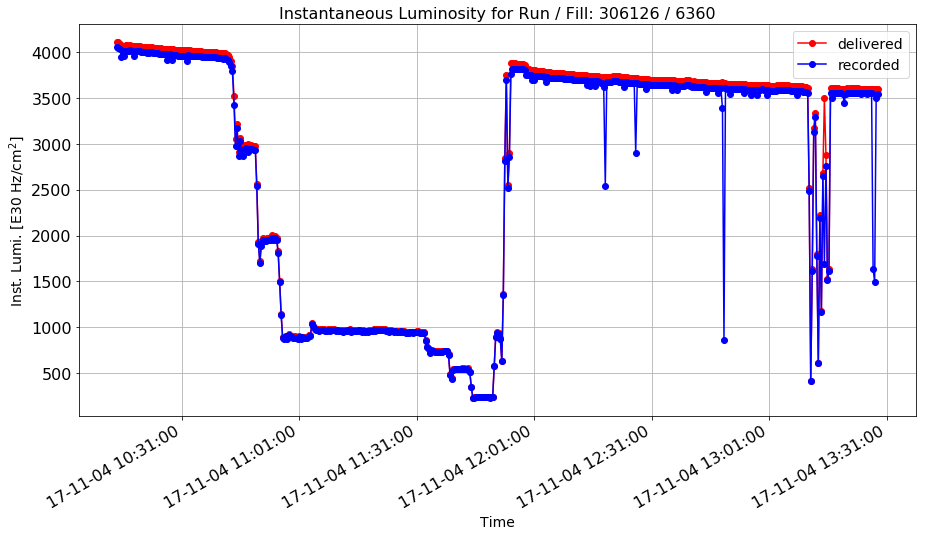

In [18]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306126]["time"], 
               int_lumi2[int_lumi2["run"] == 306126]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306126]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[3], int_lumi2["fill"].iloc[0])))

In [19]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [20]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [21]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [22]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

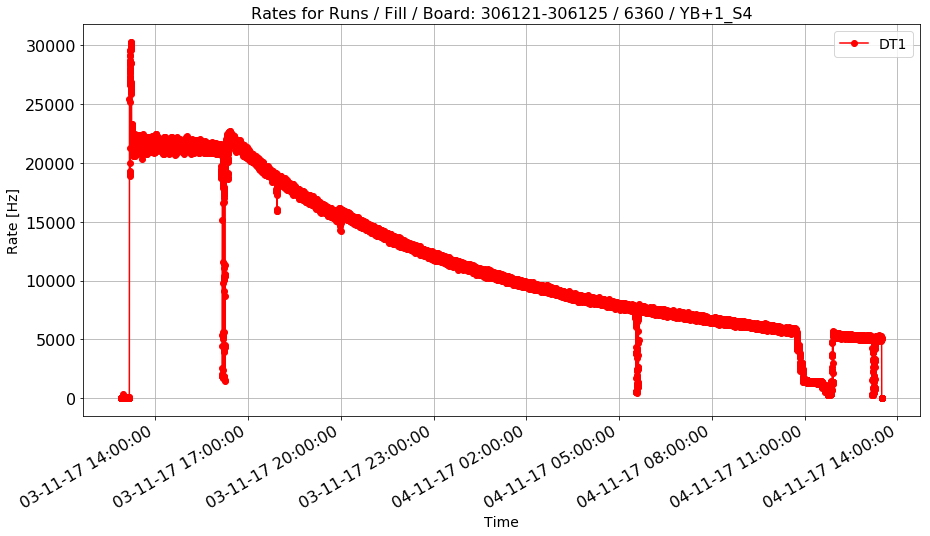

In [23]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[2]), 
                   int_lumi2["fill"].iloc[2], "YB+1_S4"))

Associating a LS and an instantaneous luminosity to each rate:

In [24]:
df_rates_backup = df_rates.copy()

In [25]:
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [26]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-11-03 13:10:09 2017-11-04 13:28:39
Duplicates: 1593649


In [27]:
print len(df_rates_noduplicates)

27011


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [28]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


Removing the few cases not assigned and that are still at -1:

In [29]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

26997


In [30]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [31]:
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [32]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print index
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000
1050000
1080000
1110000
1140000
1170000
1200000
1230000
1260000
1290000
1320000
1350000
1380000
1410000
1440000
1470000
1500000
1530000
1560000
1590000
1620000


In [33]:
#print temp[temp["time"] == "2017-11-03 13:10:13.317721"]["ls"]

In [34]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [35]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [36]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [37]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print len(df_boards)
#print df_boards

60


In [38]:
#print len(df_rates)
#print df_rates[(df_rates["ls"] == 42) & (df_rates["board"] == "YB0_S1")]["lumi"]

Too slow to use all the measurements. Averaging over 10 LS:

In [39]:
df_rates = df_rates_backup.copy()

In [40]:
def assignGroup(data, div = 10):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [41]:
#print df_rates["group"]

In [42]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4": "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

In [43]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

df_rates = df_rates.round(4)

In [44]:
#print df_rates

In [45]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
#df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False
Empty DataFrame
Columns: []
Index: []


In [46]:
#df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates.csv", sep='\t')

In [47]:
#df_rates = df_rates_backup.copy()

In [48]:
print len(df_rates)

22740


Check one case:

In [49]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

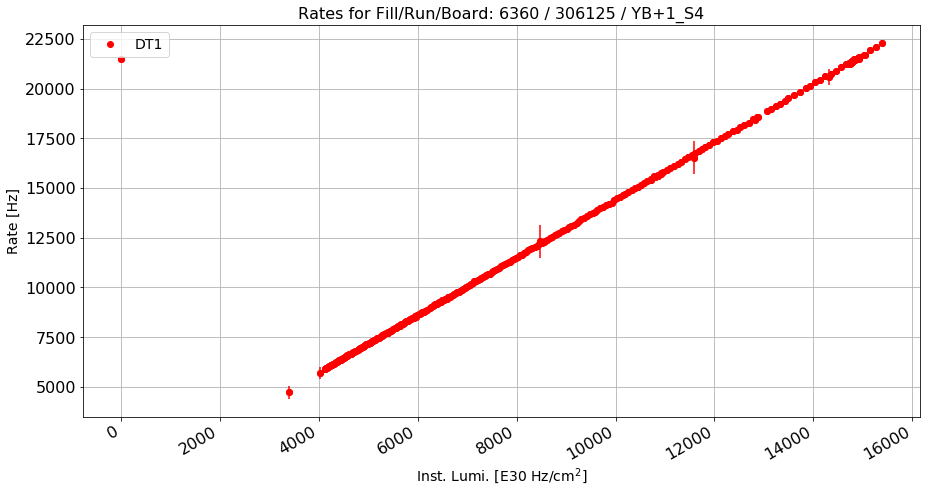

In [50]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"

plot_rate_vs_ls(df_rates, 306125, "lumi", "DT1", "YB+1_S4", 0, "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

Create a new dataframe with the input features already organized in a numpy array:

In [51]:
print df_rates.columns

Index([u'run', u'group', u'board', u'wheel', u'sector', u'ls', u'lumi',
       u'RPC1', u'RPC2', u'RPC3', u'RPC4', u'DT1', u'DT2', u'DT3', u'DT4',
       u'DT5', u'errDT1', u'errDT2', u'errDT3', u'errDT4', u'errDT5',
       u'errLumi', u'errRPC1', u'errRPC2', u'errRPC3', u'errRPC4', u'counts'],
      dtype='object')


In [52]:
#algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5']
algos = ['DT1', 'DT2', 'DT3', 'DT4', 'DT5']
df_rates_new = pd.DataFrame(columns=["run", "wheel", "sector", "station", "content", "score"])
k = 0
for index, row in df_rates.iterrows():
    for j in algos:
        k = k + 1
        if(k%5000 == 0):
            print k
        #print j
        system = -1
        station = -1
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        #num = j.replace("RPC", "")
        num = j.replace("DT", "")
        station = int(num)
        array = [system, row["wheel"], row["sector"], station, row[j], row["err"+j], row["lumi"], row["errLumi"]]
        #print array
        df_rates_new = df_rates_new.append({"run":row["run"],
                                            "wheel":row["wheel"], 
                                            "sector":row["sector"], 
                                            "station":station, 
                                            "group":row["group"], 
                                            "content":array, 
                                            "score":-1}, ignore_index=True)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000


# Model training section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [53]:
normalies = df_rates_new.copy()
anomalies = df_rates_new.copy()

In [54]:
print len(normalies), len(anomalies)

113700 113700


In [55]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344]
Anomalous chimney:
[2, 1, 4, 3, 3071.4035, 40.4563, 17987.064, 173.3344]


In [56]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [57]:
rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [58]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        group = df.loc[i]["group"]
        run = df.loc[i]["run"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) &\
            (df["group"] == group) & (df["run"] == run)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[4] #good rate from the symmetric sector
            err = array[5] #uncertainty on the good rate from the symmetric sector
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = rate
            content[5] = err
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = -1
            content[5] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [59]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344]
Anomalous chimney:
[2, 1, 4, 3, 4032.193, 53.42, 17987.064, 173.3344]


In [60]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print "Normal chimney:"
print anomalies[rule]["content"].iloc[0]

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print "Anomalous chimney:"
print anomalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4032.193, 53.42, 17987.064, 173.3344]
Anomalous chimney:
[2, 1, 4, 3, 3071.4035, 40.4563, 17987.064, 173.3344]


In [61]:
#Scale the data
def scale_data(data):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [62]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [126]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[anomalies.score == 1]
normalies = normalies[normalies.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

379 faults and 113700 good samples. In total: 114079.


In [127]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 303
Number of normal in the train set: 90960
Number of anomalies in the test set: 76
Number of normal in the test set: 22740


In [128]:
#print anomalies

In [129]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [130]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 8),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 8),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 8))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [131]:
def cae_generate_input():
    return np.array(np.concatenate(normalies_train.content_scaled.values)).reshape(-1, 8)

train_cae = cae_generate_input()

In [132]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print cw

{0: 0.50166281882146002, 1: 150.84710743801654}


Defining NN structure:

In [133]:
def neural_network():
    model = Sequential()
    model.add(Reshape((8, 1), input_shape=(8,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(32, activation='relu', name="dense_ann4"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def autoencoder():
    from keras.layers import Input, Dense
    from keras.models import Model
    input_ = Input(shape=(8,))
    encoded = Dense(8, activation='relu')(input_)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(6, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    encoded = Dense(4, activation='relu')(encoded)
    encoded = Dense(3, activation='relu')(encoded)
    decoded = Dense(3, activation='relu')(encoded)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(5, activation='relu')(decoded)
    decoded = Dense(6, activation='relu')(decoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(8, activation='sigmoid')(decoded)

    autoencoder = Model(input_, decoded)
    return autoencoder

In [134]:
ann = neural_network()
cae = autoencoder()
print("Neural Network Architecture:")
ann.summary()
print("Autoencoder Architecture:")
cae.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 8, 1)              0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 8)                 0         
_________________________________________________________________
dense_ann (Dense)            (None, 32)                288       
_________________________________________________________________
dense_ann2 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_ann3 (Dense)           (None, 32)                1056      
_________________________________________________________________
dense_ann4 (Dense)           (None, 32)                1056      
_________________________________________________________________
output_ann (Dense)           (None, 2)         

Training the NN:

In [135]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [136]:
history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00474: early stopping


In [137]:
history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)

Epoch 00214: early stopping


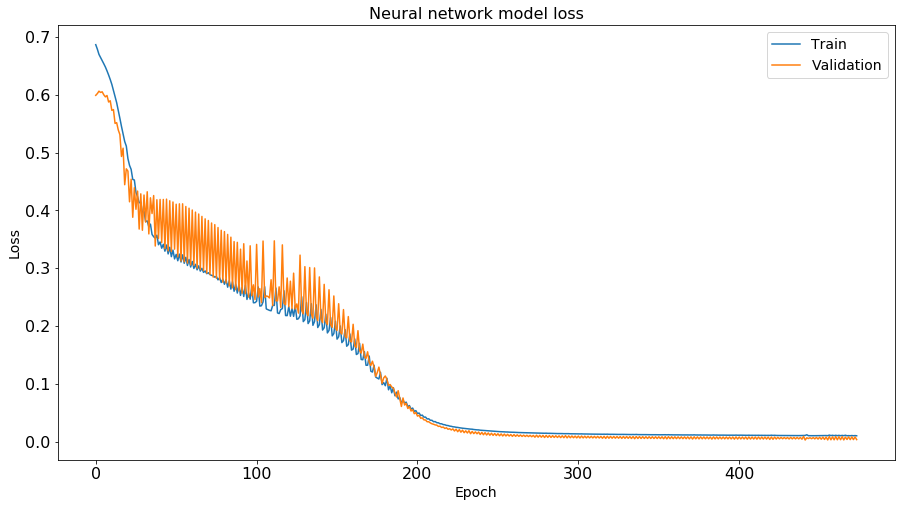

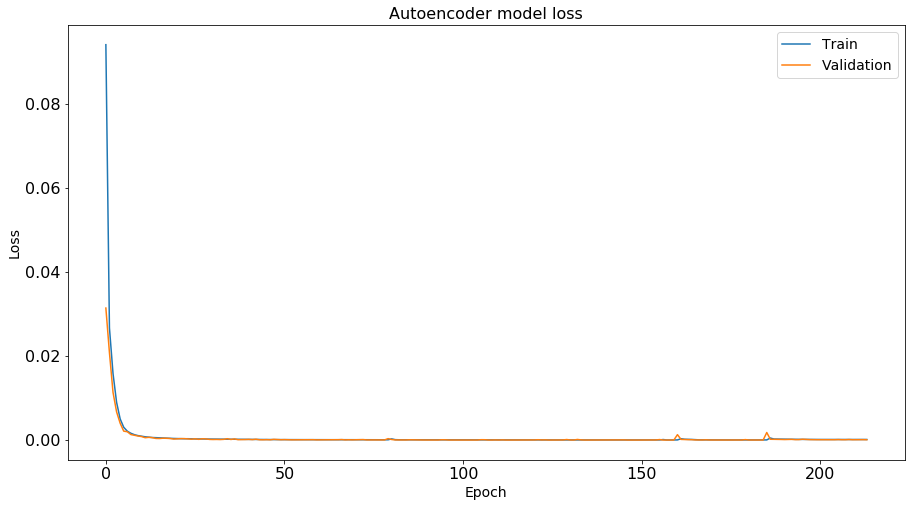

In [138]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right")
    #plt.yscale("log")
    plt.show();

plot_training_loss(history_ann.history, "Neural network model loss")
plot_training_loss(history_cae.history, "Autoencoder model loss")

Making an inference using the model and the test sample:

In [139]:
ann_model = load_model("./model_keras/ann.h5")
cae_model = load_model("./model_keras/cae.h5")

In [140]:
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [141]:
#print layers_test["ann_score"]
#print layers_test["score"]

In [142]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score"], 0.2)
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.02)

Model accuracy: 0.9997
Model sensitivity: 0.9868
Model specificity: 0.9997
Model accuracy: 0.9386
Model sensitivity: 1.0
Model specificity: 0.9384


In [215]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

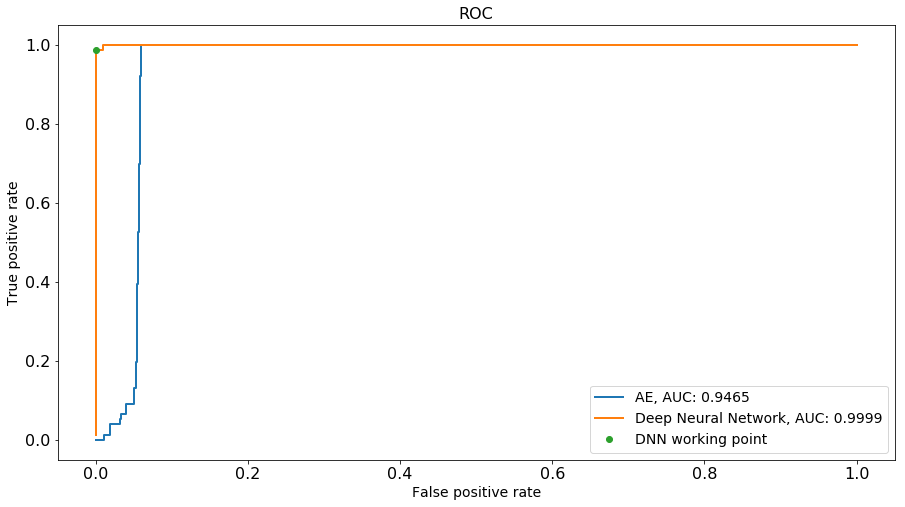

In [216]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("Deep Neural Network", "ann_score"),
               ], (specificity_ann, sensitivity_ann))

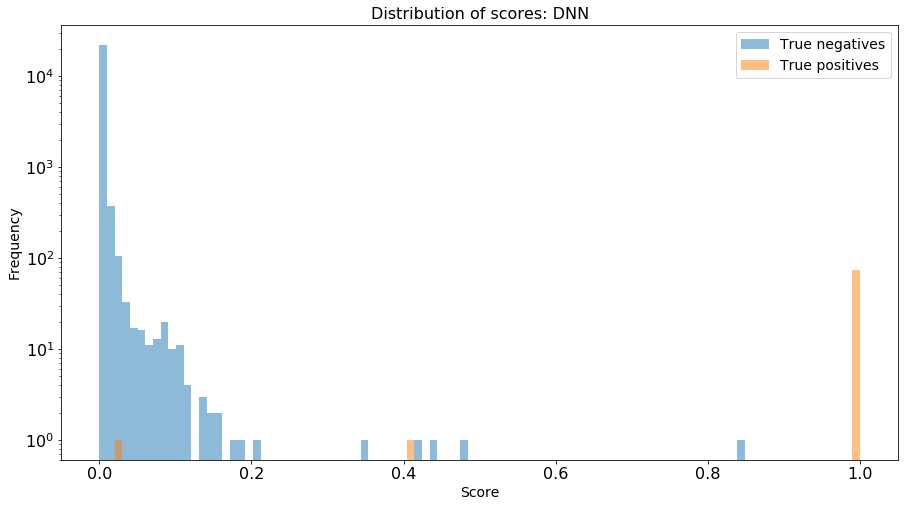

In [217]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: DNN")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

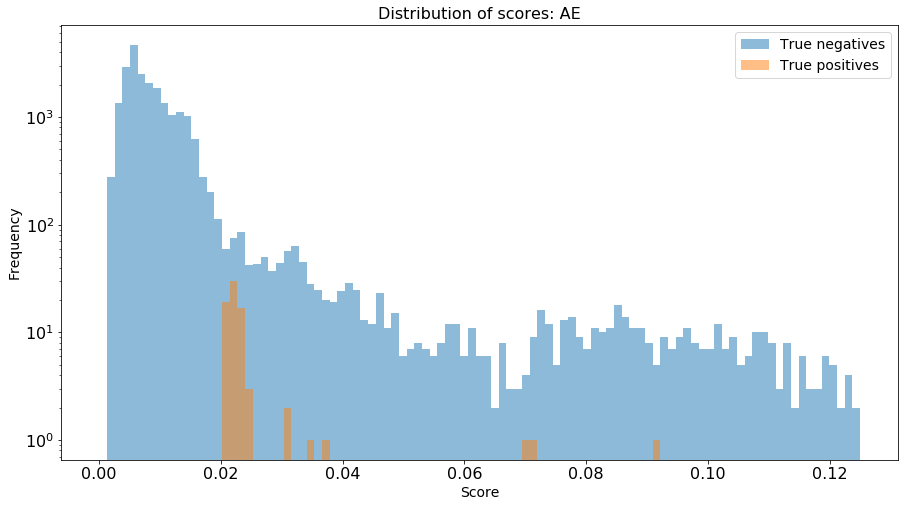

In [146]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [147]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[  9.99956025e-01   4.39753738e-05]
 [  2.63157895e-02   9.73684211e-01]]


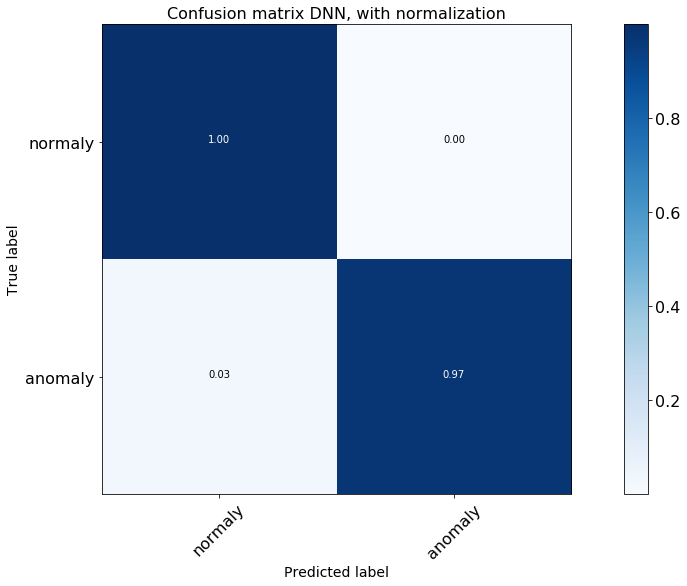

In [218]:
threshold = 0.5
y_pred = 2*(layers_test["ann_score"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix DNN, with normalization')

Normalized confusion matrix
[[ 0.9383905  0.0616095]
 [ 0.         1.       ]]


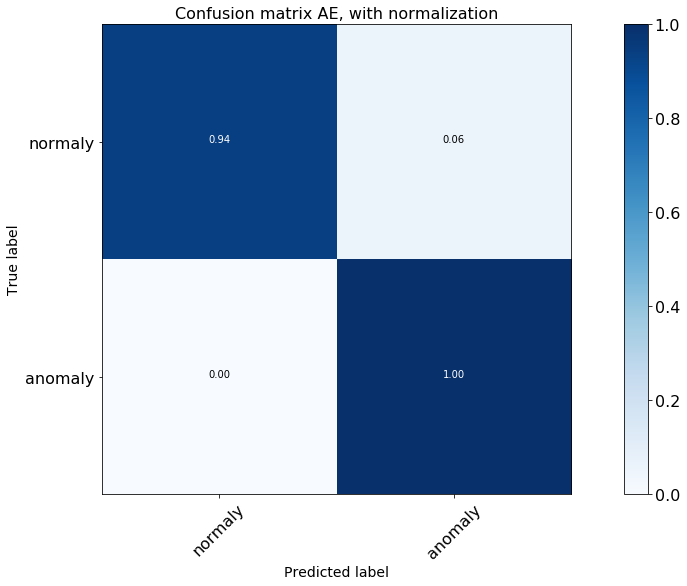

In [219]:
threshold = 0.02
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix AE, with normalization')

In [168]:
print len(layers_test[(layers_test["score"] == -1) & (layers_test["ann_score"] > 0.5)])

1


In [151]:
print len(layers_test[(layers_test["score"] == -1) & (layers_test["cae_score"] > 0.02)])

1401


In [152]:
layers_test["name"] = ("W" + layers_test["wheel"].astype(str) + "_S" + layers_test["sector"].astype(str) +\
       "_St" + layers_test["station"].astype(str))

In [220]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['name']).size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 10]
    #print df_temp
    return len(df_temp), df_temp

num_fp_ann, fp_ann = count_fp(layers_test, "ann_score", 0.5, False)
num_fp_cae, fp_cae = count_fp(layers_test, "cae_score", 0.02, True)

print "False positives DNN:", num_fp_ann
print "False positives AE:", num_fp_cae
fp_cae.set_index("name",drop=True,inplace=True)
fp_ann.set_index("name",drop=True,inplace=True)

False positives DNN: 1
False positives AE: 12


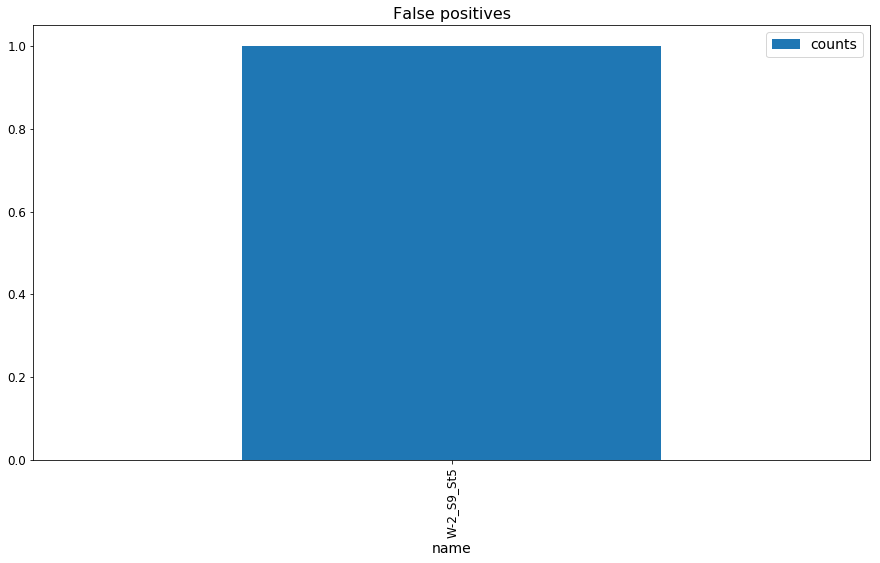

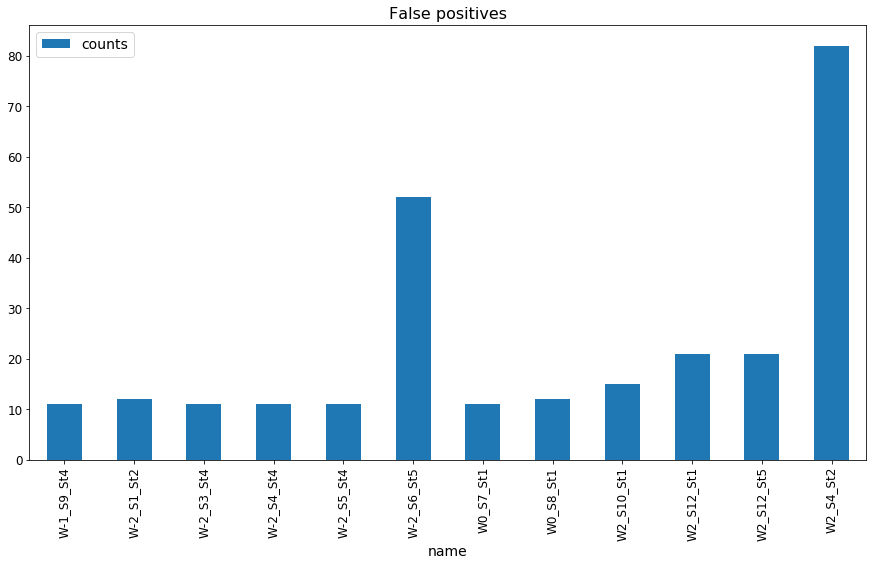

In [170]:
#print fp_cae
fp_ann.plot(kind='bar', title ="False positives", legend=True, fontsize=12)
fp_cae.plot(kind='bar', title ="False positives", legend=True, fontsize=12)

In [174]:
def variance(content):
    return np.var(content)
layers_test["variance_score"] = layers_test["content"].apply(variance)

In [175]:
#print layers_test["variance_score"]

In [159]:
def cross_validation_split(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [180]:
param_grid = [{"max_samples": [100, 1000],
               "n_estimators": [10, 100],
               "contamination": np.array(range(4, 13, 1))/100.0}]

ifparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
                                 -layers_train["score"].astype(int),
                                 IsolationForest(random_state=rng, 
                                                 #verbose=1
                                                ),
                                 param_grid)

In [196]:
# Retrain IF using all unlabelled samples

ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)

ifclf.fit(np.vstack(normalies_train["content_scaled"].values))

IsolationForest(bootstrap=False, contamination=0.040000000000000001,
        max_features=1.0, max_samples=100, n_estimators=10, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x14c5e2c30>, verbose=0)

Use SVM as outlier detection?

In [ ]:
# This may take some time...

param_grid = [{"nu": np.array(range(1, 10, 2))/10.0,
               "gamma": ["auto", 0.01, 0.001, 0.0001],
               "kernel": ["linear"]}]

svmparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
                                  -layers_train["score"].astype(int),
                                  svm.OneClassSVM(random_state=rng, 
                                                  verbose=1
                                                 ),
                                  param_grid)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [194]:
# Retrain SVM using only good samples
print svmparams
svmclf = svm.OneClassSVM(nu=svmparams.nu,
                         gamma=svmparams.gamma,
                         kernel=svmparams.kernel,
                         random_state=rng)
svmclf.fit(np.vstack(normalies_train["content_scaled"].values))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.20000000000000001,
      random_state=<mtrand.RandomState object at 0x13c89baf0>,
      shrinking=True, tol=0.001, verbose=1)


In [197]:
layers_test["svm_score"] = -svmclf.decision_function(np.vstack(layers_test["content_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(np.vstack(layers_test["content_scaled"].values))

In [270]:
from sklearn import neighbors
knclf = neighbors.KNeighborsClassifier(20, weights='distance')
knclf.fit(np.vstack(layers_train["content_scaled"].values),\
          -layers_train["score"].astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='distance')

In [271]:
layers_test["kn_score"] = -knclf.predict(np.vstack(layers_test["content_scaled"].values))

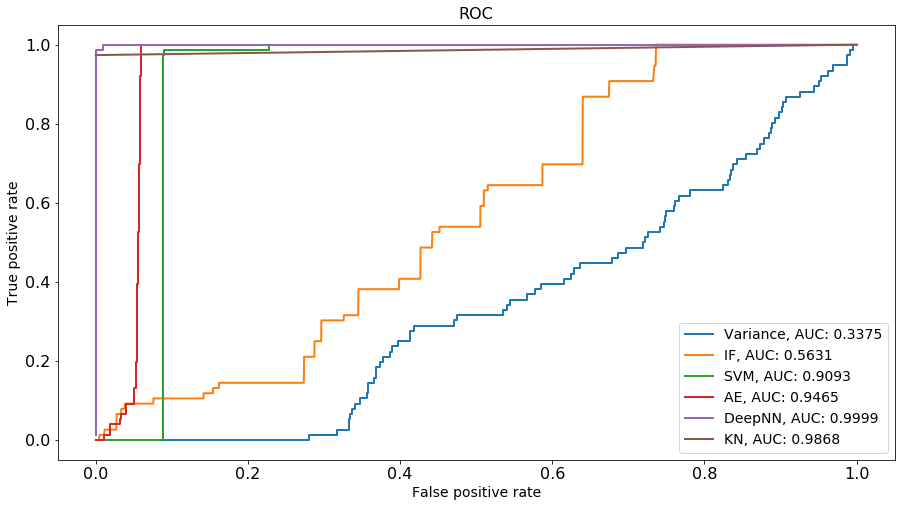

In [272]:
get_roc_curve(layers_test,[("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("DeepNN", "ann_score"),
                           ("KN", "kn_score")
                          ]
             )

In [255]:
# fit the model
from sklearn.neighbors import LocalOutlierFactor
lofclf = LocalOutlierFactor(n_neighbors=30)
layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))

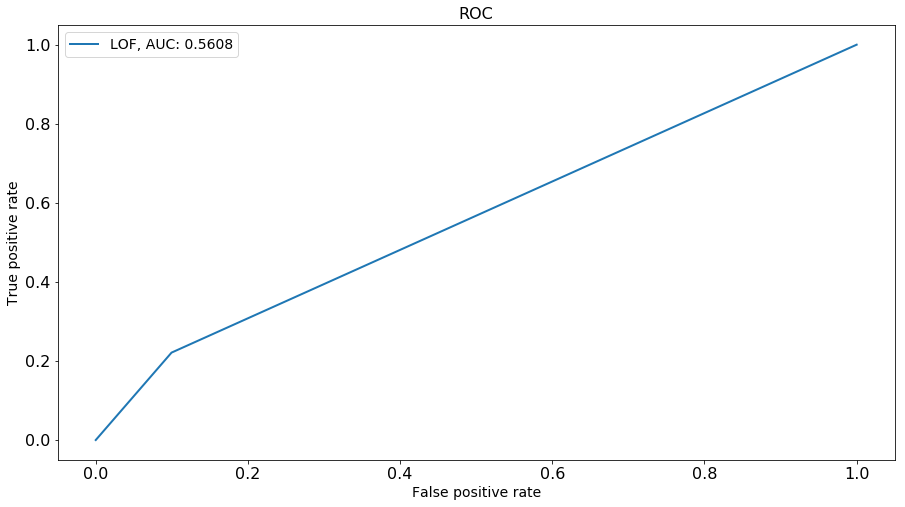

In [256]:
get_roc_curve(layers_train,[("LOF", "lof_score")])

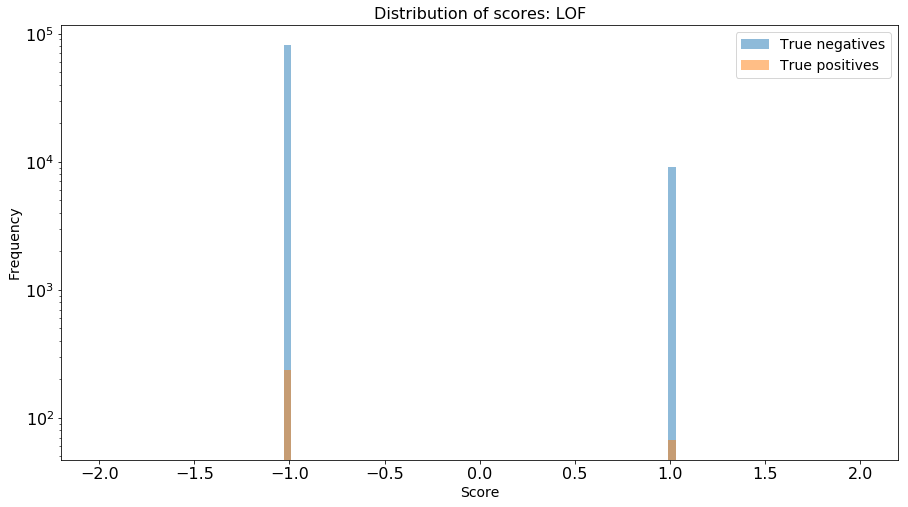

In [257]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(-2, +2, 100)
plt.hist(layers_train[layers_train["score"] < 0]["lof_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_train[layers_train["score"] > 0]["lof_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()